# Transfer Learning

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import sys
from time import time
import numpy as np
import pandas as pd
from pprint import pprint
from glob import glob

import sklearn
from collections import OrderedDict
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import lightgbm as lgb

SEED = 42

In [2]:
# import torch
# from torch import nn, optim
# from torch.optim import lr_scheduler
# import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
# import copy
# print(torch.__version__)

In [3]:
import keras
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Lambda, merge
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop, Adadelta
from keras.models import Sequential, Model, model_from_json, model_from_yaml, load_model
from keras.utils import np_utils, multi_gpu_model
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard    
print(keras.__version__)

Using TensorFlow backend.


2.2.4


In [4]:
# medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
def krs_reg_tidy(input_dim, dr_rate=0.2, opt_name='sgd', kernel_initializer='he_uniform', logger=None):
    inputs = Input(shape=(input_dim,), name='inputs')

    layers = [1000, 500, 250, 125, 60]
    for i, l_size in enumerate(layers):
        if i == 0:
            x = Dense(l_size, kernel_initializer=kernel_initializer, name=f'fc{i+1}')(inputs)
        else:
            x = Dense(l_size, kernel_initializer=kernel_initializer, name=f'fc{i+1}')(x)
        x = BatchNormalization(name=f'bn{i+1}')(x)
        x = Activation('relu', name=f'a{i+1}')(x)
        x = Dropout(dr_rate, name=f'drp{i+1}')(x)
        
#     x = Dense(1000, name='fc1')(inputs)
#     x = BatchNormalization(name='bn1')(x)
#     x = Activation('relu')(x)

#     x = Dense(1000, name='fc2')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(dr_rate)(x)

#     x = Dense(500, name='fc3')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(dr_rate)(x)

#     x = Dense(250, name='fc4')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(dr_rate)(x)

#     x = Dense(125, name='fc5')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(dr_rate)(x)

#     x = Dense(60, name='fc6')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(dr_rate)(x)

#     x = Dense(30, name='fc7')(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(dr_rate)(x)

    outputs = Dense(1, activation='relu', name='outputs')(x)
    model = Model(inputs=inputs, outputs=outputs)

    if opt_name == 'sgd':
        opt = SGD(lr=1e-4, momentum=0.9)
    elif opt_name == 'adam':
        opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    else:
        opt = SGD(lr=1e-4, momentum=0.9) # for clr

    model.compile(loss='mean_squared_error',
                  optimizer=opt,
                  metrics=['mae'])
    return model

In [5]:
# Data path

# Top6 from Rick
# datadir = Path('../data/processed/topN/topNrick/')
# datapath = datadir/'uniq.top6.reg.parquet'

# Top6 from code
# datadir = Path('../data/processed/topN/topNcode/')
# datapath = datadir/'top_6.res_reg.cf_rnaseq.dd_dragon7.labled.parquet'

dirpath = Path('../../data/processed/data_splits/gdsc_cv_simple_te_simple_combat/')

In [6]:
# Args
os.environ["CUDA_VISIBLE_DEVICES"]="1";

target_name = 'AUC'
cv_folds = 1

epochs = 100
batch_size = 32
n_jobs = 4
verbose=1

In [7]:
# Load data
if (dirpath/'xdata.parquet').is_file():
    xdata = pd.read_parquet( dirpath/'xdata.parquet', engine='auto', columns=None )
    meta = pd.read_parquet( dirpath/'meta.parquet', engine='auto', columns=None )
    ydata = meta[[target_name]]

tr_id = pd.read_csv( dirpath/f'{cv_folds}fold_tr_id.csv' ).values.reshape(-1,)
vl_id = pd.read_csv( dirpath/f'{cv_folds}fold_vl_id.csv' ).values.reshape(-1,)
te_id = pd.read_csv( dirpath/'te_id.csv' ).values.reshape(-1,)

src = dirpath.name.split('_')[0]

print('tr_id', len(tr_id))
print('vl_id', len(vl_id))
print('te_id', len(te_id))

tr_id 119011
vl_id 3000
te_id 13556


In [8]:
# Take subset of training samples for faster development
n = 40000
tr_id = np.random.permutation(len(tr_id))[:n]

In [9]:
# Train / val / test
xtr = xdata.iloc[tr_id]
xvl = xdata.iloc[vl_id]
xte = xdata.iloc[te_id]

ytr = ydata.iloc[tr_id]
yvl = ydata.iloc[vl_id]
yte = ydata.iloc[te_id]

print(xtr.shape, ytr.shape)
print(xvl.shape, yvl.shape)
print(xte.shape, yte.shape)

(40000, 3762) (40000, 1)
(3000, 3762) (3000, 1)
(13556, 3762) (13556, 1)


In [10]:
# Scale
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()

cols = xtr.columns
xtr = pd.DataFrame(scaler.fit_transform(xtr), columns=cols, dtype=np.float32)
xvl = pd.DataFrame(scaler.transform(xvl), columns=cols, dtype=np.float32)
xte = pd.DataFrame(scaler.transform(xte), columns=cols, dtype=np.float32)

# Train base NN  model

https://github.com/keras-team/keras/issues/8772<br>
https://forums.fast.ai/t/how-to-finetune-with-new-keras-api/2328/4

In [4]:
# base_model = krs_reg_tidy(input_dim=xtr.shape[1], dr_rate=0.2, opt_name='sgd')
# fit_kwargs = {'epochs': epochs, 'batch_size': batch_size, 'verbose': 1}

In [5]:
# base_model.summary()

In [6]:
# history = base_model.fit(xtr, ytr, **fit_kwargs)

In [7]:
# # Save model
# base_model.save('base_nn_model.h5')

In [8]:
# # Predict
# pred_ytr = base_model.predict(xtr)

# # Calc scores
# tr_scores = {}
# tr_scores['r2'] = r2_score(ytr, pred_ytr)
# tr_scores['mae'] = mean_absolute_error(ytr, pred_ytr)
# print(tr_scores)

# Transfer Learning

In [5]:
def print_trainable_layers(model, print_all=False):
    """ Print the trainable state of layers. """
    print('Trainable layers:')
    for layer in model.layers:
        if layer.trainable:
            print(layer.name, layer.trainable)
        if not layer.trainable and print_all:
            print(layer.name, layer.trainable)

def freeze_layers(model, layers_ids='all'):
    # freeze_layers = ['1', '2', '3', '4']
    if layers_ids=='all':
        for layer in ft_model.layers:
            layer.trainable = False
            
    for layer in ft_model.layers:
        if any([True for i in layers_ids if i in layer.name]):
            layer.trainable = False
            
def pop_layers(model, layers_ids):
    # pop_layers = ['4', '5', 'outputs']
    model_layers = fe_model.layers
    for layer in model_layers[::-1]:
        if any([True for i in layers_ids if i in layer.name]):
            fe_model.layers.pop()            

In [11]:
base_model_dir = Path('../../out/trns_lrn/train_base_model_keras/GDSC.nn_reg0.sgd.ep200.drp0.2_2019-7-21_h19-m25')

# base_model_name = 'GDSC.nn_reg0.sgd.ep200.drp0.2_2019-7-21_h19-m25'
# base_model_path = base_model_dir / base_model_name
# base_model_path
                      
base_model_dir

PosixPath('../../out/trns_lrn/train_base_model_keras/GDSC.nn_reg0.sgd.ep200.drp0.2_2019-7-21_h19-m25')

In [14]:
tl_data_dir = Path('/vol/ml/apartin/projects/pilot1/data/yitan/Data/tidy/CCLE.geneGE.DD')
# tl_data_name = 'CCLE.geneGE.DD'
# tl_data_path = tl_data_dir / tl_data_name
# src = tl_data_name.split('.')[0]
# tl_data_path

src = str(tl_data_dir).split('/')[-1].split('.')[0]

'CCLE'

In [9]:
# Functions for getting tidy data (Yitan's partitions)

def extract_subset_fea(df, fea_list, fea_sep='_'):
    """ Extract features based feature prefix name. """
    fea = [c for c in df.columns if (c.split(fea_sep)[0]) in fea_list]
    df = df[fea]
    return df

def extract_data(df, fea_list):
    """ ... """
    X = extract_subset_fea(df, fea_list=fea_list, fea_sep='_')
    Y = df[['auc']]
    meta = df.drop(columns=X.columns)
    meta = meta.drop(columns=['auc'])
    return X, Y, meta

def load_data(dirpath, src, fold=0, ccl_fea_list=['geneGE'], drg_fea_list=['DD']):
    data_fpath = Path((glob(str(dirpath/'*data.parquet')))[0])
    assert data_fpath.is_file(), '*data.parquet file was not found.'
    data = pd.read_parquet( data_fpath )
    print('\ndata {}'.format(data.shape))

    # Path to data splits
    datadir = Path('../../data/yitan/Data')
    ccl_folds_dir = Path('../../data/yitan/CCL_10Fold_Partition')
    pdm_folds_dir = Path('../../data/yitan/PDM_10Fold_Partition')

    # fold = 0
    # ccl_fea_list = ['geneGE']
    # drg_fea_list = ['DD']
    fea_sep = '_'

    ids_path = ccl_folds_dir/f'{src}/cv_{fold}' # 'TestList.txt'
    tr_ids_list = pd.read_csv(ids_path/'TrainList.txt', header=None).squeeze().values
    vl_ids_list = pd.read_csv(ids_path/'ValList.txt', header=None).squeeze().values
    te_ids_list = pd.read_csv(ids_path/'TestList.txt', header=None).squeeze().values

    data_tr = data[ data['cclname'].isin( tr_ids_list ) ]
    data_vl = data[ data['cclname'].isin( vl_ids_list ) ]
    data_te = data[ data['cclname'].isin( te_ids_list ) ]

    print('data_tr {}'.format(data_tr.shape))
    print('data_vl {}'.format(data_vl.shape))
    print('data_te {}'.format(data_te.shape))

    xtr, ytr, mtr = extract_data(data_tr, fea_list = ccl_fea_list + drg_fea_list)
    xvl, yvl, mvl = extract_data(data_vl, fea_list = ccl_fea_list + drg_fea_list)
    xte, yte, mte = extract_data(data_te, fea_list = ccl_fea_list + drg_fea_list)

    # Scale
    cols = xtr.columns
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    # scaler = RobustScaler()

    cols = xtr.columns
    xtr = pd.DataFrame(scaler.fit_transform(xtr), columns=cols, dtype=np.float32)
    xvl = pd.DataFrame(scaler.transform(xvl), columns=cols, dtype=np.float32)
    xte = pd.DataFrame(scaler.transform(xte), columns=cols, dtype=np.float32)
    
    return xtr, xvl, xte

In [10]:
xtr, xvl, xte = load_data(dirpath=tl_data_dir, src=src)


data (10971, 4254)
data_tr (8755, 4254)
data_vl (1117, 4254)
data_te (1099, 4254)


## Baseline methods

1. Train model from scratch on tf set
2. Predict on the tf set

### 1. Train model from scratch

In [14]:
# NN
b1_model = krs_reg_tidy(input_dim=xvl.shape[1], dr_rate=0.2, opt_name='sgd')
fit_kwargs = {'epochs': epochs, 'batch_size': batch_size, 'verbose': False}
history = b1_model.fit(xvl, yvl, **fit_kwargs)

# Predict
pred_yvl = b1_model.predict(xvl)

# Calc scores
b1_scores = {}
b1_scores['r2'] = r2_score(yvl, pred_yvl)
b1_scores['mae'] = mean_absolute_error(yvl, pred_yvl)
print(b1_scores)

W0721 09:44:07.621711 140460894680896 deprecation_wrapper.py:119] From /vol/ml/apartin/anaconda3/envs/p1_/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 09:44:07.635463 140460894680896 deprecation_wrapper.py:119] From /vol/ml/apartin/anaconda3/envs/p1_/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0721 09:44:07.699430 140460894680896 deprecation_wrapper.py:119] From /vol/ml/apartin/anaconda3/envs/p1_/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 09:44:07.700080 140460894680896 deprecation_wrapper.py:119] From /vol/ml/apartin/anaconda3/envs/p1_/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default

{'r2': 0.15539364998812022, 'mae': 0.11746149}


In [14]:
# LGBM
init_kwargs = {'objective': 'regression', 'n_estimators': 100, 'n_jobs': n_jobs, 'random_state': SEED}    
lgbm = lgb.LGBMModel(**init_kwargs)

# Train
fit_kwargs = {'verbose': verbose}
t0 = time()
lgbm.fit(xvl, yvl, **fit_kwargs)
print('Train time: {:.2f} mins'.format( (time()-t0)/60 ))

# Predict
pred_yvl = lgbm.predict(xvl)

# Calc scores
lgbm_scores = {}
lgbm_scores['r2'] = r2_score(yvl, pred_yvl)
lgbm_scores['mae'] = mean_absolute_error(yvl, pred_yvl)
print(lgbm_scores)

Train time: 0.23 mins
{'r2': 0.9445182351870955, 'mae': 0.02806745983643786}


### 2. Predict on target data

In [16]:
# Predict
base_model = load_model('base_nn_model.h5')
pred_yvl = base_model.predict(xvl)

# Scores
b2_scores = {}
b2_scores['r2'] = r2_score(yvl, pred_yvl)
b2_scores['mae'] = mean_absolute_error(yvl, pred_yvl)
print(b2_scores)

{'r2': 0.38410798985450023, 'mae': 0.092168786}


# Transfer learning methods
1. Freeze all layers, and reinitialize the last n layers (n=1, 2, ...)
2. Freeze all layers, and finetune the last n layers (n=1, 2, ...)
3. Freeze all layers, fea extract for tf, and then supply the extracted fea to LightGBM

### 1. Freeze all layers, and reinitialize the last n layers (n=1, 2, ...)

In [17]:
pass

### 2. Freeze all layers, and finetune the last n layers (n=1, 2, ...)

In [64]:
ft_model = load_model('base_nn_model.h5')

opt = SGD(lr=1e-4, momentum=0.9)
# opt = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
ft_model.compile(loss='mean_squared_error',
                 optimizer=opt,
                 metrics=['mae'])

In [65]:
print_trainable_layers(ft_model, print_all=True)

Trainable layers:
fc1 True
bn1 True
a1 True
dropout1 True
fc2 True
bn2 True
a2 True
dropout2 True
fc3 True
bn3 True
a3 True
dropout3 True
fc4 True
bn4 True
a4 True
dropout4 True
fc5 True
bn5 True
a5 True
dropout5 True
outputs True


In [66]:
# def fintune(model, freeze_layers, x, y, epoch=10, batch_size=32, verbose=False):
#     freeze_layers = ['1', '2', '3', '4', '5']
#     for layer in model.layers:
#         if any([True for i in freeze_layers if i in layer.name]):
#             layer.trainable = False
            
#     fit_kwargs = {'epochs': epochs, 'batch_size': batch_size, 'verbose': verbose}
#     history = model.fit(x, y, **fit_kwargs)
#     return model

In [67]:
freeze_layers(ft_model, layers_ids=['1', '2', '3', '4'])
print_trainable_layers(ft_model, print_all=True)

Trainable layers:
inputs False
fc1 False
bn1 False
a1 False
dropout1 False
fc2 False
bn2 False
a2 False
dropout2 False
fc3 False
bn3 False
a3 False
dropout3 False
fc4 False
bn4 False
a4 False
dropout4 False
fc5 True
bn5 True
a5 True
dropout5 True
outputs True


In [68]:
ft_epochs = 20
fit_kwargs = {'epochs': ft_epochs, 'batch_size': batch_size, 'verbose': 0}
history = ft_model.fit(xvl, yvl, **fit_kwargs)

In [69]:
pred_yvl = ft_model.predict(xvl)

# Calc scores
ft2_scores = {}
ft2_scores['r2'] = r2_score(yvl, pred_yvl)
ft2_scores['mae'] = mean_absolute_error(yvl, pred_yvl)
print(ft2_scores)

{'r2': 0.3907791476276462, 'mae': 0.092816226}


### 3. Freeze all layers, fea extract, and then supply the extracted fea to LightGBM

In [70]:
fe_model = load_model('base_nn_model.h5')
print_trainable_layers(fe_model, print_all=True)

Trainable layers:
inputs False
fc1 True
bn1 True
a1 True
dropout1 True
fc2 True
bn2 True
a2 True
dropout2 True
fc3 True
bn3 True
a3 True
dropout3 True
fc4 True
bn4 True
a4 True
dropout4 True
fc5 True
bn5 True
a5 True
dropout5 True
outputs True


In [71]:
pop_layers(fe_model, layers_ids=['4','5','outputs'])
print_trainable_layers(fe_model, print_all=True)

Trainable layers:
inputs False
fc1 True
bn1 True
a1 True
dropout1 True
fc2 True
bn2 True
a2 True
dropout2 True
fc3 True
bn3 True
a3 True
dropout3 True


In [72]:
fe_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 3762)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1000)              3763000   
_________________________________________________________________
bn1 (BatchNormalization)     (None, 1000)              4000      
_________________________________________________________________
a1 (Activation)              (None, 1000)              0         
_________________________________________________________________
dropout1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 500)               500500    
_________________________________________________________________
bn2 (BatchNormalization)     (None, 500)               2000      
__________

In [108]:
print(fe_model.layers[0].name)
print(fe_model.layers[0].input)
print(fe_model.layers[0].output)
print('')

print(fe_model.layers[1].name)
print(fe_model.layers[1].input)
print(fe_model.layers[1].output)
print('')

print(fe_model.layers[-1].name)
print(fe_model.layers[-1].input)
print(fe_model.layers[-1].output)
print('')

print(fe_model.inputs)
print(fe_model.outputs)

inputs
Tensor("inputs_14:0", shape=(?, 3762), dtype=float32)
Tensor("inputs_14:0", shape=(?, 3762), dtype=float32)

fc1
Tensor("inputs_14:0", shape=(?, 3762), dtype=float32)
Tensor("fc1_14/BiasAdd:0", shape=(?, 1000), dtype=float32)

dropout3
Tensor("a3_14/Relu:0", shape=(?, 250), dtype=float32)
Tensor("dropout3_14/cond/Merge:0", shape=(?, 250), dtype=float32)

[<tf.Tensor 'inputs_14:0' shape=(?, 3762) dtype=float32>]
[<tf.Tensor 'outputs_14/Relu:0' shape=(?, 1) dtype=float32>]


In [112]:
# Create feature extractor model
fea_extractor_model = Model(inputs=fe_model.input, outputs=fe_model.layers[-1].output)

In [113]:
fea_extractor_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 3762)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 1000)              3763000   
_________________________________________________________________
bn1 (BatchNormalization)     (None, 1000)              4000      
_________________________________________________________________
a1 (Activation)              (None, 1000)              0         
_________________________________________________________________
dropout1 (Dropout)           (None, 1000)              0         
_________________________________________________________________
fc2 (Dense)                  (None, 500)               500500    
_________________________________________________________________
bn2 (BatchNormalization)     (None, 500)               2000      
__________

In [115]:
print(fea_extractor_model.inputs)
print(fea_extractor_model.outputs)

[<tf.Tensor 'inputs_14:0' shape=(?, 3762) dtype=float32>]
[<tf.Tensor 'dropout3_14/cond/Merge:0' shape=(?, 250) dtype=float32>]


In [120]:
xvl_fea = fea_extractor_model.predict(xvl)
print(xvl_fea.shape)

(3000, 250)


In [123]:
# Now train shallow model
# LGBM
init_kwargs = {'objective': 'regression', 'n_estimators': 100, 'n_jobs': n_jobs, 'random_state': SEED}    
lgbm = lgb.LGBMModel(**init_kwargs)

# Train
fit_kwargs = {'verbose': verbose}
t0 = time()
lgbm.fit(xvl_fea, yvl, **fit_kwargs)
print('Train time: {:.2f} mins'.format( (time()-t0)/60 ))

# Predict
pred_yvl = lgbm.predict(xvl_fea)

# Calc scores
fea_ext_scores = {}
fea_ext_scores['r2'] = r2_score(yvl, pred_yvl)
fea_ext_scores['mae'] = mean_absolute_error(yvl, pred_yvl)
print(fea_ext_scores)

Train time: 0.02 mins
{'r2': 0.9349332144023743, 'mae': 0.031395217119620546}


# Create mini Top6

In [4]:
# data = pd.read_parquet(datapath, engine='auto', columns=None)
# data = data.sample(frac=1.0, axis=0, random_state=SEED).reset_index(drop=True)
# print(data.shape)

# col_idx = data.nunique(dropna=True).values == 1  # col indexes to drop
# data = data.iloc[:, ~col_idx]
# print(data.shape)

# def subset(data, s):
#     if s <= 1.0:
#         data_size = int(data.shape[0]*s)
#     return data[:data_size]

# data = subset(data, s=0.3)
# print(data.shape)
# # data.to_csv(datadir/'uniq.top6.reg.mini.csv', index=False)
# data.to_parquet(datadir/'uniq.top6.reg.mini.parquet', index=False)

# display(data[:3])

# Load and pre-process

In [5]:
# Load data
# data = pd.read_csv(datadir/'uniq.top6.reg.mini.csv')
data = pd.read_parquet(datadir/'uniq.top6.reg.mini.parquet')
print(data.shape)

if 'topNcode' in str(datadir):
    data.drop(columns=['CELL', 'DRUG'], inplace=True)

(85501, 3763)


In [6]:
# Split train/test
df_tr, df_vl = train_test_split(data, test_size=0.2)
df_tr = df_tr.reset_index(drop=True)
df_vl = df_vl.reset_index(drop=True)
print(df_tr.shape)
print(df_vl.shape)

# Split features/target
ytr, xtr = df_tr.iloc[:,0], df_tr.iloc[:,1:]
yvl, xvl = df_vl.iloc[:,0], df_vl.iloc[:,1:]

del data, df_tr, df_vl

(68400, 3761)
(17101, 3761)


In [7]:
# Scale
col = xtr.columns

scaler = StandardScaler()
xtr = pd.DataFrame( scaler.fit_transform(xtr), columns=col ).astype(np.float32)
xvl = pd.DataFrame( scaler.transform(xvl), columns=col ).astype(np.float32)

print(xtr.shape, ytr.shape)
print(xvl.shape, yvl.shape)

(68400, 3760) (68400,)
(17101, 3760) (17101,)


# PyTorch
https://nbviewer.jupyter.org/github/FraPochetti/KagglePlaygrounds/blob/master/NYC%20Taxi%20Fares%20Prediction.ipynb

In [8]:
# # Simple example

# x = torch.Tensor([[1, 2, 3], [1, 2, 3]]).view(-1, 2)
# y = torch.Tensor([[2, 1]]).view(2, -1)

# print('x.shape', x.shape)
# print('y.shape', y.shape)

# print('\nx\n', x)
# print('\ny\n', y)
# print('\nx * y\n', torch.mm(x, y))

# Dataset

In [9]:
class DatasetTidy(Dataset):
    # discuss.pytorch.org/t/data-processing-as-a-batch-way/14154
    # github.com/utkuozbulak/pytorch-custom-dataset-examples#incorporating-pandas
    # nbviewer.jupyter.org/github/FraPochetti/KagglePlaygrounds/blob/master/NYC%20Taxi%20Fares%20Prediction.ipynb
    def __init__(self,
                 X: pd.DataFrame,
                 Y: pd.DataFrame):
        # xdata and ydata are pandas dfs
        X = pd.DataFrame(X).values
        Y = pd.DataFrame(Y).values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.Y = self.Y.view(-1, 1)
        
        # xdata and ydata are torch tensors
        #self.x = xdata
        #self.y = ydata
        #self.y = self.y.view(-1, 1)        
        
    def __len__(self):
        return len(self.Y)
        
    def __getitem__(self, idx):
        X = self.X[idx, :]
        Y = self.Y[idx]
        return X, Y

In [10]:
tr_ds = DatasetTidy(X=xtr, Y=ytr)
vl_ds = DatasetTidy(X=xvl, Y=yvl)

# Dataloaders

In [11]:
# Define data loaders
batch_size = 32
num_workers = 1
tr_loader_kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers}
vl_loader_kwargs = {'batch_size': 4*batch_size, 'shuffle': False, 'num_workers': num_workers}

tr_loader = DataLoader(tr_ds, **tr_loader_kwargs)
vl_loader = DataLoader(vl_ds, **vl_loader_kwargs)

In [12]:
# xb, yb = next(iter(tr_loader))
# print(xb.shape, yb.shape)
# print(xb[:2])
# print(yb[:2])

# Network

In [13]:
# class NN_REG(nn.Module):
#     def __init__(self, input_dim):
#         super().__init__()
#         self.fc1 = nn.Linear(input_dim, 1000)
#         self.fc2 = nn.Linear(1000, 1000)
#         self.fc3 = nn.Linear(1000, 500)
#         self.fc4 = nn.Linear(500, 250)
#         self.fc5 = nn.Linear(250, 125)
#         self.fc6 = nn.Linear(125, 60)
#         self.fc7 = nn.Linear(60, 30)
#         self.fc8 = nn.Linear(30, 1)
#         self.dropout = nn.Dropout(0.2)
        
#     def forward(self, x):
#         x = self.dropout(F.relu(self.fc1(x)))
#         x = self.dropout(F.relu(self.fc2(x)))
#         x = self.dropout(F.relu(self.fc3(x)))
#         x = self.dropout(F.relu(self.fc4(x)))
#         x = self.dropout(F.relu(self.fc5(x)))
#         x = self.dropout(F.relu(self.fc6(x)))
#         x = self.dropout(F.relu(self.fc7(x)))
#         x = F.relu(self.fc8(x))
#         return x

In [14]:
class NN_REG(nn.Module):
    def __init__(self, input_dim, dr_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 250)
        self.fc4 = nn.Linear(250, 60)
        self.fc5 = nn.Linear(60, 1)
        self.dropout = nn.Dropout(dr_rate)
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = F.relu(self.fc5(x))
        return x

In [15]:
def weight_init_linear(m: nn.Module):
    """
    Pytorch initializes the layers by default (e.g., Linear uses kaiming_uniform_)
    www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/weight_initialization_activation_functions/
    stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch
    github.com/xduan7/UnoPytorch/blob/master/networks/initialization/weight_init.py
    """
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# Model to CUDA

In [16]:
def get_model_device(model):
    return str(next(model.parameters()).device)

In [17]:
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
# print(device)

In [18]:
# pytorch.org/docs/stable/cuda.html
# towardsdatascience.com/speed-up-your-algorithms-part-1-pytorch-56d8a4ae7051
print('is_available:  ', torch.cuda.is_available())
print('device_name:   ', torch.cuda.get_device_name(0))
print('device_count:  ', torch.cuda.device_count())
print('current_device:', torch.cuda.current_device())

is_available:   True
device_name:    GeForce RTX 2080 Ti
device_count:   4
current_device: 0


In [19]:
# Choose device
device = torch.device('cuda:3')

# Move model to CUDA device
model = NN_REG(input_dim=tr_ds.X.shape[1]).to(device) # send model to gpu/cpu device
model.apply(weight_init_linear)

# Query device where the model is located
print(get_model_device(model))
print('current_device:', torch.cuda.current_device()) # why current device is 0??

cuda:3
current_device: 0


In [20]:
# if device.type == 'cuda':
#     print(get_model_device(model))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3, 1), 'GB')

In [21]:
# # Choose cuda device with context manager
# with torch.cuda.device(2):
#     print('\ncurrent_device:', torch.cuda.current_device())
#     model = NN_REG(input_dim=tr_ds.x.shape[1]).to(device=device)
# print('current_device:', torch.cuda.current_device())

# Loss function and optimizer

In [22]:
loss_fnc = nn.MSELoss(reduction='mean')
opt = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)  # pytorch.org/docs/stable/optim.html
# lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer=opt, base_lr=1e-5, max_lr=1e-3, mode='triangular')

### Try a single training iteration

In [23]:
# xx, yy = next(iter(tr_loader))
# xx = xx.to(device)
# yy = yy.to(device)
# print(xx.device)
# print(yy.device)

# # Forward
# opt.zero_grad()
# pred = model(xx)

# print(f'pred.shape {pred.shape}')
# print(f'yb.shape {yy.shape}')
# yy = yy.view(pred.shape)
# print(f'yb.shape {yy.shape}\n')

# print('pred:\n', pred[:3])
# print('yy:\n', yy[:3])
# pred = pred.type(torch.float32)
# print('pred:\n', pred[:3])

# # Backprop
# loss = loss_fnc(pred, yy)
# loss.backward() # compute loss gradients wrt to model parameters and inputs
# opt.step()      # update model parameters;  pytorch.org/docs/stable/optim.html

In [24]:
# print(f'pred.shape {pred.shape}')
# print(f'yb.shape   {yb.shape}\n')
# mae = torch.abs(pred - yb)
# r2_torch(y_true=yb, y_pred=pred)

## Training loop

In [25]:
# discuss.pytorch.org/t/what-does-torch-backends-cudnn-benchmark-do/5936
# groups.google.com/forum/#!topic/torch7/CkB57025yRY
# torch.backends.cudnn.benchmark = True

In [26]:
def r2_torch(y_true, y_pred):
    epsilon = 1e-7  # this epsilon value used in TF
    SS_res = torch.sum( (y_true - y_pred)**2 )
    SS_tot = torch.sum( (y_true - torch.mean(y_true))**2 )
    r2 = 1 - SS_res / (SS_tot + epsilon)
    return r2

In [27]:
# def calc_reg_scores(pred, true, metrics, val=False):
#     prfx = 'val_' if val is True else '' 
#     scores = {}
    
#     for m in metrics:
#         if 'loss' in m:
#             continue
            
#         elif m in ['mean_abs_err', 'mean_absolute_error']:
#             scores[prfx + 'mean_abs_err'] = torch.mean(torch.abs(pred-true))

#         elif m in ['median_abs_err', 'median_absolute_error']:
#             scores[prfx + 'median_abs_err'] = torch.median(torch.abs(pred-true))

#         elif m in ['mean_sqrd_err', 'mean_squared_error']:
#             scores[prfx + 'mean_sqrd_err'] = torch.mean(torch.pow(pred-true, 0.5))  # or torch.mean(torch.sqrt(pred-true))
            
#         elif m in ['r2', 'r2_score']:
#             scores[prfx + 'r2'] = r2_torch(y_true=true, y_pred=pred)
            
#     return scores

In [28]:
def update_scores_reg(pred, true, scores):
    """ Updates score metrics for regression ML predictions.
    The scores are summed for every call of the function (single func call corresponds a single batch).
    
    Note: these must be implemented with pytroch commands! Otherwise, results gives error:
    RuntimeError: Can't call numpy() on Variable that requires grad. Use var.detach().numpy() instead.   
    pred, true = pred.numpy(), yy.numpy()
    tr_mae += sklearn.metrics.mean_absolute_error(true, pred)
    tr_r2 += sklearn.metrics.r2_score(true, pred)
    """
    for m in scores.keys():
        if 'loss' in m:
            continue
            
        elif any([True if v in m else False for v in ['mean_abs_err', 'mean_absolute_error']]):
            scores[m] += torch.mean( torch.abs(pred-true) ).item()

        elif any([True if v in m else False for v in ['median_abs_err', 'median_absolute_error']]):
            scores[m] += torch.median( torch.abs(pred-true) ).item()

        elif any([True if v in m else False for v in ['mean_sqrd_err', 'mean_squared_error']]):
            scores[m] += torch.mean( torch.pow(pred-true, 0.5) ).item()  # or torch.mean(torch.sqrt(pred-true))
            
        elif any([True if v in m else False for v in ['r2', 'r2_score']]):
            scores[m] += r2_torch(y_true=true, y_pred=pred).item()
            
    return scores

In [29]:
def proc_batch(x_dct, y, model, loss_fnc, opt=None):
    """ 
    Args:
        opt (torch.optim) : no backprop is performed if optimizer is not provided (for val or test) 
    """    
    pred = model(**x_dct)
    pred = pred.type(y.dtype)
    loss = loss_fnc(pred, y)
    
    # Backward pass
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
        
    return loss, pred

In [30]:
def fit(model: nn.Module,
        loss_fnc,
        opt: torch.optim,
        tr_dl: torch.utils.data.DataLoader,
        vl_dl: torch.utils.data.DataLoader=None,
        epochs: int=1,
        device: torch.device='cuda:0',
        verbose: bool=True,
        metrics=[]) -> dict:
    """ github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
    Args:
        metrics (list) : list of metric scores to log
            (available metrics: 'mean_abs_err','median_abs_err', 'mean_sqrd_err', 'r2)
    """ 
    # Create dicts to log scores
    if vl_dl is None:
        logs = OrderedDict({'loss': []})
        logs.update(OrderedDict({m: [] for m in metrics}))        
    else:
        logs = OrderedDict({'loss': [], 'val_loss': []})
        for m in metrics: logs.update(OrderedDict({m: [], 'val_'+m: []}))
    
    # Iter over epochs
    phases = ['train', 'val'] if vl_dl is not None else ['train']
    for ep in range(epochs):
        ep_t0 = time()
        # lr_scheduler.step()
        
        for ph in phases:
            if ph == 'train':
                model.train()
                dl = tr_dl
                scores = {m: 0 for m in logs.keys() if 'val' not in m}
                loss_name = 'loss'
            elif ph == 'val':
                model.eval()
                dl = vl_dl
                scores = {m: 0 for m in logs.keys() if 'val' in m}
                loss_name = 'val_loss'

            # Iter over batches
            for x, y in dl:
                y = y.to(device)
                x = x.to(device)
                x_dct = {'x': x} # new
                
                # Process batch
                if ph == 'train':
                    loss, pred = proc_batch(x_dct, y, model=model, loss_fnc=loss_fnc, opt=opt)
                else:
                    loss, pred = proc_batch(x_dct, y, model=model, loss_fnc=loss_fnc, opt=None)

                # Compute metrics (running avg)
                scores[loss_name] += loss.item()
                scores = update_scores_reg(pred=pred, true=y, scores=scores)
            
            # Log scores
            for m in scores.keys():
                logs[m].append(scores[m]/len(dl))
            
        del x, y, loss, pred, scores
        
        if verbose:
            print(f'Epoch {ep+1}/{epochs}; ',
                  f'{int(time()-ep_t0)}s; ',
                  [f'{k}: {v[-1]:.3f}' for k, v in logs.items()])
            
        # TODO: log scores into file

    return model, logs

In [31]:
epochs = 30
metrics = ['mean_abs_err', 'r2']
verbose = False
fit_kwargs = {'epochs': epochs, 'device': device, 'metrics': metrics, 'verbose': verbose}

t0 = time()
base_model, logs = fit(model = model,
                       loss_fnc = loss_fnc,
                       opt = opt,
                       tr_dl = tr_loader,
                       vl_dl = vl_loader,
                       **fit_kwargs)
print('{}'.format( (time()-t0)/60 ))

# Transfer Learning

Baseline methods:

1. Train model from scratch on tf set
2. Predict on the tf set

Transfer learning methods:
1. Freeze all layers, and reinitialize the last n layers (n=1, 2, ...)
2. Freeze all layers, and finetune the last n layers (n=1, 2, ...)
3. Freeze all layers, fea extract for tf, and then supply the extracted fea to LightGBM

In [32]:
def set_parameter_requires_grad(model, fea_extract):
    if fea_extract:
        for param in model.parameters():
            param.requires_grad = False

In [33]:
def check_model_grad(model):
    for name, param in model.named_parameters():
        print('{} grad: {}'.format(name, param.requires_grad))

### Baseline 1 (train from scratch xvl) --> need CV scores

In [34]:
# init_kwargs = {'objective': 'regression', 'n_estimators': 100, 'n_jobs': n_jobs, 'random_state': SEED}    
# b1_model = lgb.LGBMModel(**init_kwargs)

# # Train
# b1_model.fit(xvl, yvl)

# # Predict
# pred_yvl = b1_model.predict(xvl)

# # Scores
# b1_scores = {}
# b1_scores['r2_vl'] = r2_score(yvl, pred_yvl)
# b1_scores['mae_vl'] = mean_absolute_error(yvl, pred_yvl)

In [35]:
# b1_model = NN_REG(input_dim=vl_ds.x.shape[1]).to(device) # send model to gpu/cpu device
# b1_model.apply(weight_init_linear)

# epochs = 20
# metrics = ['mean_abs_err', 'r2']
# verbose = False
# fit_kwargs = {'epochs': epochs, 'device': device, 'metrics': metrics, 'verbose': verbose}

# # Train
# t0 = time()
# b1_model, logs = fit(model = b1_model,
#                      loss_fnc = loss_fnc,
#                      opt = opt_ft,
#                      tr_dl = trnsf_loader,
#                      **fit_kwargs)
# print('{} mins'.format( (time()-t0)/60 ))

# # Predict
# pass

# # Scores
# b1_scores = {}
# b1_scores['r2_vl'] = r2_score(yvl, pred_yvl)
# b1_scores['mae_vl'] = mean_absolute_error(yvl, pred_yvl)

### Baseline 2 (predict xvl)

In [ ]:
def calc_scores(m, x, y):
    x = torch.tensor(x.values, requires_grad=False, dtype=torch.float32).to(device)
    pred = m(x).cpu().detach().numpy()
    scores = {}
    scores['r2'] = r2_score(y, pred)
    scores['mae'] = mean_absolute_error(y, pred)
    return scores

In [36]:
# xtr_torch = torch.tensor(xtr.values, requires_grad=False, dtype=torch.float32).to(device)
xvl_torch = torch.tensor(xvl.values, requires_grad=False, dtype=torch.float32).to(device)

# Predict
# pred_ytr = model(xtr_torch).cpu().detach().numpy()
pred_yvl = base_model(xvl_torch).cpu().detach().numpy()

# Scores
b2_scores = {}
# b2_scores['r2_tr'] = r2_score(ytr, pred_ytr)
b2_scores['r2_vl'] = r2_score(yvl, pred_yvl)
# b2_scores['mae_tr'] = mean_absolute_error(ytr, pred_ytr)
b2_scores['mae_vl'] = mean_absolute_error(yvl, pred_yvl)

pprint(b2_scores)

{'mae_vl': 0.09317579840885173, 'r2_vl': 0.3403574532179806}


### Transfer learn 1 (freeze all; reinitialize last *n*)

In [37]:
check_model_grad(base_model)

fc1.weight grad: True
fc1.bias grad: True
fc2.weight grad: True
fc2.bias grad: True
fc3.weight grad: True
fc3.bias grad: True
fc4.weight grad: True
fc4.bias grad: True
fc5.weight grad: True
fc5.bias grad: True


In [38]:
# Freeze all layers, and reinitialize the last layer
fea_extract = True
model_ft = copy.deepcopy(base_model)

set_parameter_requires_grad(model_ft, fea_extract)

model_ft.fc5 = nn.Linear(model_ft.fc5.in_features, model_ft.fc5.out_features)

In [39]:
check_model_grad(model_ft)

fc1.weight grad: False
fc1.bias grad: False
fc2.weight grad: False
fc2.bias grad: False
fc3.weight grad: False
fc3.bias grad: False
fc4.weight grad: False
fc4.bias grad: False
fc5.weight grad: True
fc5.bias grad: True


In [40]:
# Keep the old model to compare weights later (make sure that the frozed layers stay unchanged)
model_ft_old = copy.deepcopy(model_ft)

In [41]:
model_ft.fc5.weight.data

tensor([[ 0.0306, -0.0024, -0.0440, -0.0927, -0.0622,  0.0093,  0.0598, -0.0715,
         -0.1164,  0.1261,  0.0054,  0.0346,  0.1018, -0.1051,  0.0793, -0.1260,
          0.1151,  0.1185,  0.0354,  0.0446, -0.0551, -0.0308, -0.0680,  0.0981,
          0.0890, -0.0649,  0.0451, -0.0464, -0.0915,  0.0737, -0.0213, -0.0230,
          0.0936,  0.0543,  0.0761,  0.0776, -0.0152, -0.1106,  0.0751, -0.0411,
         -0.0245,  0.0010,  0.0429,  0.1153, -0.0590,  0.0163, -0.0392,  0.0539,
         -0.0837, -0.0567, -0.0109, -0.0303,  0.0376,  0.0332, -0.0507, -0.1164,
          0.0029,  0.0363,  0.1094,  0.0071]])

In [42]:
model_ft_old.fc5.weight.data

tensor([[ 0.0306, -0.0024, -0.0440, -0.0927, -0.0622,  0.0093,  0.0598, -0.0715,
         -0.1164,  0.1261,  0.0054,  0.0346,  0.1018, -0.1051,  0.0793, -0.1260,
          0.1151,  0.1185,  0.0354,  0.0446, -0.0551, -0.0308, -0.0680,  0.0981,
          0.0890, -0.0649,  0.0451, -0.0464, -0.0915,  0.0737, -0.0213, -0.0230,
          0.0936,  0.0543,  0.0761,  0.0776, -0.0152, -0.1106,  0.0751, -0.0411,
         -0.0245,  0.0010,  0.0429,  0.1153, -0.0590,  0.0163, -0.0392,  0.0539,
         -0.0837, -0.0567, -0.0109, -0.0303,  0.0376,  0.0332, -0.0507, -0.1164,
          0.0029,  0.0363,  0.1094,  0.0071]])

In [43]:
# Dataset
ft_ds = DatasetTidy(X=xvl, Y=yvl)
# ft_ds = ds_vl

In [44]:
# Dataloader
batch_size = 32
num_workers = 1
ft_loader_kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers}
# vl_loader_kwargs = {'batch_size': 4*batch_size, 'shuffle': False, 'num_workers': num_workers}

ft_loader = DataLoader(ft_ds, **ft_loader_kwargs)
# vl_loader = DataLoader(vl_ds, **vl_loader_kwargs)

In [45]:
model_ft = model_ft.to(device)

In [46]:
# Create optimizer that updates the desired parameters.

# We make a list of such parameters and input this list to the SGD algorithm constructor.
# To verify this, check out the printed parameters to learn. When finetuning, this list should be long
# and include all of the model parameters. However, when feature extracting this list should be short
# and only include the weights and biases of the reshaped layers.

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True

params_to_update = model_ft.parameters()
print("Params to learn:")
if fea_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
opt_ft = optim.SGD(params_to_update, lr=1e-4, momentum=0.9)

Params to learn:
	 fc5.weight
	 fc5.bias


In [47]:
epochs = 30
metrics = ['mean_abs_err', 'r2']
verbose = False
fit_kwargs = {'epochs': epochs, 'device': device, 'metrics': metrics, 'verbose': verbose}

model_ft, logs = fit(model = model_ft,
                     loss_fnc = loss_fnc,
                     opt = opt_ft,
                     tr_dl = ft_loader,
                     vl_dl = None,
                     **fit_kwargs)

In [48]:
xvl_torch = torch.tensor(xvl.values, requires_grad=False, dtype=torch.float32).to(device)
pred_yvl = model_ft(xvl_torch).cpu().detach().numpy()

t_scores1 = {}
t_scores1['r2_vl'] = r2_score(yvl, pred_yvl)
t_scores1['mae_vl'] = mean_absolute_error(yvl, pred_yvl)

pprint(t_scores1)

{'mae_vl': 0.09364312459260747, 'r2_vl': 0.28525338764636476}


In [50]:
# why this doesn't work ?!
# print(next(model_ft_old.named_parameters()))
# print(next(model_ft.named_parameters()))
# torch.allclose(model_ft_old.fc5.weight, model_ft.fc5.weight)

In [51]:
display(model_ft_old.fc5.weight.data)

tensor([[ 0.0306, -0.0024, -0.0440, -0.0927, -0.0622,  0.0093,  0.0598, -0.0715,
         -0.1164,  0.1261,  0.0054,  0.0346,  0.1018, -0.1051,  0.0793, -0.1260,
          0.1151,  0.1185,  0.0354,  0.0446, -0.0551, -0.0308, -0.0680,  0.0981,
          0.0890, -0.0649,  0.0451, -0.0464, -0.0915,  0.0737, -0.0213, -0.0230,
          0.0936,  0.0543,  0.0761,  0.0776, -0.0152, -0.1106,  0.0751, -0.0411,
         -0.0245,  0.0010,  0.0429,  0.1153, -0.0590,  0.0163, -0.0392,  0.0539,
         -0.0837, -0.0567, -0.0109, -0.0303,  0.0376,  0.0332, -0.0507, -0.1164,
          0.0029,  0.0363,  0.1094,  0.0071]])

In [52]:
model_ft.fc5.weight.data

tensor([[ 0.0322, -0.0027,  0.0077, -0.0810, -0.0611,  0.0099,  0.0602, -0.0682,
         -0.1152,  0.1215,  0.0191,  0.0389,  0.0691, -0.0508,  0.0792,  0.0170,
          0.0005,  0.1183,  0.0345,  0.0458,  0.0092, -0.0090, -0.0205,  0.0980,
          0.0176, -0.0649,  0.0110, -0.0458,  0.0185,  0.0738,  0.0144, -0.0144,
          0.0141,  0.0186,  0.0759,  0.0763, -0.0124, -0.0475,  0.0752, -0.0408,
          0.0169,  0.0067,  0.0095,  0.1149, -0.0568,  0.0212, -0.0383, -0.0617,
         -0.0816,  0.0110, -0.0109, -0.0305,  0.0109,  0.0093, -0.0492, -0.1154,
          0.0197,  0.0363,  0.1059,  0.0078]], device='cuda:3')

In [ ]:
del model_ft

### Transfer learn 2 (freeze all, finetune last *n*)

In [54]:
check_model_grad(base_model)

fc1.weight grad: True
fc1.bias grad: True
fc2.weight grad: True
fc2.bias grad: True
fc3.weight grad: True
fc3.bias grad: True
fc4.weight grad: True
fc4.bias grad: True
fc5.weight grad: True
fc5.bias grad: True


In [55]:
# Freeze all layers, and reinitialize the last layer
fea_extract = True
model_ft = copy.deepcopy(base_model)
set_parameter_requires_grad(model_ft, fea_extract)
# model_ft.fc5 = nn.Linear(model_ft.fc5.in_features, model_ft.fc5.out_features)

In [57]:
check_model_grad(model_ft)

fc1.weight grad: False
fc1.bias grad: False
fc2.weight grad: False
fc2.bias grad: False
fc3.weight grad: False
fc3.bias grad: False
fc4.weight grad: False
fc4.bias grad: False
fc5.weight grad: False
fc5.bias grad: False


In [ ]:
# next(model_ft.fc5.parameters()).requires_grad

In [63]:
for name, param in model_ft.named_parameters():
    if 'fc5' in name:
        param.requires_grad = True

In [64]:
check_model_grad(model_ft)

fc1.weight grad: False
fc1.bias grad: False
fc2.weight grad: False
fc2.bias grad: False
fc3.weight grad: False
fc3.bias grad: False
fc4.weight grad: False
fc4.bias grad: False
fc5.weight grad: True
fc5.bias grad: True


In [67]:
epochs = 30
metrics = ['mean_abs_err', 'r2']
verbose = False
fit_kwargs = {'epochs': epochs, 'device': device, 'metrics': metrics, 'verbose': verbose}

model_ft, logs = fit(model = model_ft,
                     loss_fnc = loss_fnc,
                     opt = opt_ft,
                     tr_dl = ft_loader,
                     vl_dl = None,
                     **fit_kwargs)

In [68]:
xvl_torch = torch.tensor(xvl.values, requires_grad=False, dtype=torch.float32).to(device)
pred_yvl = model_ft(xvl_torch).cpu().detach().numpy()

t_scores2 = {}
t_scores2['r2_vl'] = r2_score(yvl, pred_yvl)
t_scores2['mae_vl'] = mean_absolute_error(yvl, pred_yvl)

pprint(t_scores2)

{'mae_vl': 0.09390004824685616, 'r2_vl': 0.2826980408904164}


In [ ]:
del model_ft

### Transfer learn 3 (freeze all, extract fea; train with LightGBM)

In [100]:
pass

# Plots

In [46]:
logs = pd.DataFrame(logs).reset_index().rename(columns={'index': 'epoch'})
logs['epoch'] += 1

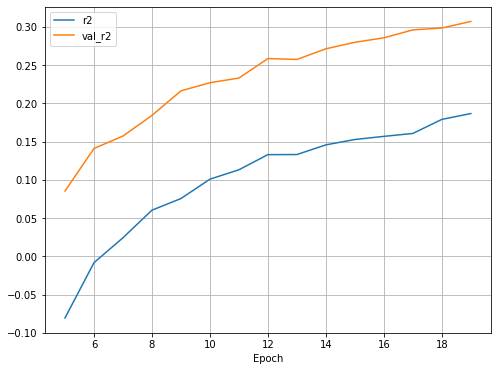

In [48]:
skp_ep = 5
plt.figure(figsize=(8,6))

# plt.plot(logs['loss'], label='loss');
# plt.plot(logs['val_loss'], label='val_loss');
# plt.legend(loc='best');

# plt.plot(logs['mean_abs_err'], label='mean_abs_err');
# plt.plot(logs['val_mean_abs_err'], label='val_mean_abs_err');
# plt.legend(loc='best');

m = 'r2'
plt.plot(logs[m][skp_ep:], label=m);
plt.plot(logs[f'val_{m}'][skp_ep:], label=f'val_{m}');
plt.xlabel('Epoch')
plt.legend(loc='best');
plt.grid(True)

In [54]:
# def fit(model: nn.Module,
#         loss_fnc,
#         opt: torch.optim,
#         tr_dl: torch.utils.data.DataLoader,
#         vl_dl: torch.utils.data.DataLoader=None,
#         epochs: int=1,
#         device: torch.device='cuda:0',
#         verbose: bool=True,
#         metrics=[]) -> dict:
#     """ github.com/stared/livelossplot/blob/master/examples/pytorch.ipynb
#     Args:
#         metrics (list) : list of metric scores to log
#             (available metrics: 'mean_abs_err','median_abs_err', 'mean_sqrd_err', 'r2)
#     """ 
#     print(f'Arg `device`: {device}')
#     model.to(device)
#     print('current_device:', torch.cuda.current_device())
    
#     # Choose cuda device with context manager --> try using context manager!!!
#     # with torch.cuda.device(device):
        
#     # Create dicts to log scores
#     if vl_dl is None:
#         logs = OrderedDict({'loss': []})
#         logs.update(OrderedDict({m: [] for m in metrics}))        
#     else:
#         logs = OrderedDict({'loss': [], 'val_loss': []})
#         for m in metrics: logs.update(OrderedDict({m: [], 'val_'+m: []}))
    
#     # Iter over epochs
#     phases = ['train', 'val'] if vl_dl is not None else ['train']
#     for ep in range(epochs):
#         ep_t0 = time()
        
#         # -------------
#         # Training loop
#         # -------------
#         model.train() # turns-on dropout for training
#         tr_scores = {m: 0 for m in logs.keys() if 'val' not in m}
        
#         for xx, yy in tr_dl:
#             xx = xx.to(device)
#             yy = yy.to(device)
            
#             # Process batch
#             loss, pred = proc_batch(xx, yy, model, loss_fnc, opt=opt)
                  
#             # Compute metrics (running avg)
#             tr_scores['loss'] += loss.item()
#             tr_scores = update_scores_reg(pred=pred, true=yy, scores=tr_scores)
                
#         for m in tr_scores.keys():
#             print(m)
#             logs[m].append(tr_scores[m]/len(tr_dl))
                
#         del xx, yy, loss, pred, tr_scores
                
#         # ---------------
#         # Validation loop
#         # ---------------        
#         if vl_dl is not None:
#             model.eval()  # turn-off dropout in inferenece
#             vl_scores = {m: 0 for m in logs.keys() if 'val' in m}
            
#             with torch.no_grad():
#                 for xx, yy in vl_dl:
#                     xx = xx.to(device)
#                     yy = yy.to(device)
                    
#                     # Process batch
#                     loss, pred = proc_batch(xx, yy, model, loss_fnc, opt=None)
                                
#                     # Compute metrics at the end of each epoch (not the running avg across the batches)
#                     vl_scores['val_loss'] += loss.item()
#                     vl_scores = update_scores_reg(pred=pred, true=yy, scores=vl_scores)
                        
#                 # Update logs
#                 for m in vl_scores.keys():
#                     print(m)
#                     logs[m].append(vl_scores[m]/len(vl_dl))
        
#                 del xx, yy, loss, pred, vl_scores
        
#         if verbose:
#             print(f'Epoch {ep+1}/{epochs}; ',
#                   f'{int(time()-ep_t0)}s; ',
#                   [f'{k}: {v[-1]:.3f}' for k, v in logs.items()])
#     return logs

In [ ]:
# verbose = True
# epochs = 10
# logs = OrderedDict({'loss': [], 'val_loss': [],
#                     'mean_abs_err': [], 'val_mean_abs_err': [],
#                     'r2': [], 'val_r2': []})

# # Choose cuda device with context manager
# with torch.cuda.device(device):
#     print('\ncurrent_device:', torch.cuda.current_device())
    
#     for ep in range(epochs):
#         ep_t0 = time()
        
#         # -------------
#         # Training loop
#         # -------------
#         model.train() # turns-on dropout for training
#         tr_loss, tr_mae, tr_r2 = 0, 0, 0

#         for xx, yy in tr_loader:
#             xx = xx.to(device) # move data to gpu/cpu device
#             yy = yy.to(device) # move data to gpu/cpu device
            
#             # Feedforward
#             pred = model(xx)
#             loss = loss_fnc(pred, yy)

#             # Backprop and optimization
#             opt.zero_grad()
#             loss.backward()   # compute loss gradients wrt to model parameters and inputs
#             opt.step()  # update model parameters;  pytorch.org/docs/stable/optim.html
            
#             # Compute metrics
#             tr_loss += loss.item() # item() returns a number from a tensor that contains a single value
#             tr_mae += torch.mean(torch.abs(pred-yy))
#             tr_r2 += r2_torch(y_true=yy, y_pred=pred)

#         tr_loss /= len(tr_loader)
#         tr_mae /= len(tr_loader)
#         tr_r2 /= len(tr_loader)
        
#         logs['loss'].append(tr_loss)
#         logs['mae'].append(tr_mae)
#         logs['r2'].append(tr_r2)

#         del xx, yy

#         # ---------------
#         # Validation loop
#         # ---------------
#         if vl_loader is not None:
#             model.eval()  # turn-off dropout in inferenece
#             with torch.no_grad():
#                 vl_loss, vl_mae, vl_r2 = 0, 0, 0

#                 for xx, yy in vl_loader:
#                     xx = xx.to(device)
#                     yy = yy.to(device)

#                     # Feedforward
#                     pred = model(xx)
#                     loss = loss_fnc(pred, yy)

#                     # Compute metrics
#                     vl_loss += loss.item() # item() returns a number from a tensor that contains a single value
#                     vl_mae += torch.mean(torch.abs(pred-yy))
#                     vl_r2 += r2_torch(y_true=yy, y_pred=pred)

#                 vl_loss /= len(vl_loader)
#                 vl_mae /= len(vl_loader)
#                 vl_r2 /= len(vl_loader)

#                 logs['val_loss'].append(vl_loss)
#                 logs['val_mae'].append(vl_mae)
#                 logs['val_r2'].append(vl_r2)

#                 del xx, yy

# #         if verbose:
# #             print(f'Epoch {ep+1}/{epochs}; ',
# #                   f'{int(time()-t0)}s; '
# #                   f'tr_loss: {tr_loss:.3f}; ',
# #                   f'vl_loss: {vl_loss:.3f}; ',
# #                   f'tr_mae: {tr_mae:.3f}; ',
# #                   f'vl_mae: {vl_mae:.3f}; ',
# #                   f'tr_r2: {tr_r2:.3f}; ',
# #                   f'vl_r2: {vl_r2:.3f}; ')
            
#         if verbose:
#             print(f'Epoch {ep+1}/{epochs}; ',
#                   f'{int(time()-ep_t0)}s; ',
#                   [f'{k}: {v[-1]:.3f}' for k, v in logs.items()])